# Tweedie Density Estimation

This package follows the following 2 papers to estimate the density of a presumed Tweedie distribution:

    Dunn, Peter K. and Smyth, Gordon K. 2001, Tweedie Family Densities: Methods
    of Evaluation

    Dunn, Peter K. and Smyth, Gordon K. 2005, Series evaluation of Tweedie
    exponential dispersion model densities

Below, I'll demonstrate a relatively simple approach to estimating Tweedie density from a given distribution. First, I'm going to generate some data and try to fit a GLM on it.

In [1]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import scipy as sp
from tweedie import tweedie
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Number of parameters for model
p = 20

# Number of simulated observations
n = 100000

np.random.seed(43)
exog = np.random.rand(n, p - 1)
exog = np.hstack((np.ones((n, 1)), exog))
beta = np.concatenate(([500], np.random.randint(-100, 100, p - 1))) / 100
eta = np.dot(exog, beta)
mu = np.exp(eta)

endog = tweedie(mu=mu, p=1.5, phi=20).rvs(n)

And to prove this is a typical Tweedie distribution, we'll plot it. Notice that there's a big point of mass at exactly 0, and then some positive values. 

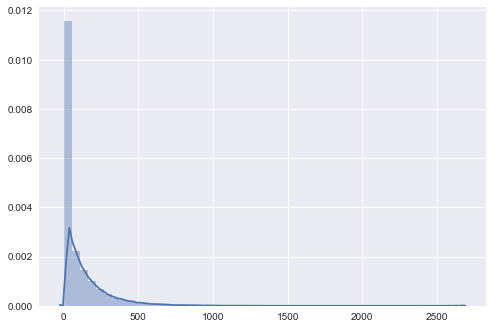

In [3]:
sns.distplot(endog)

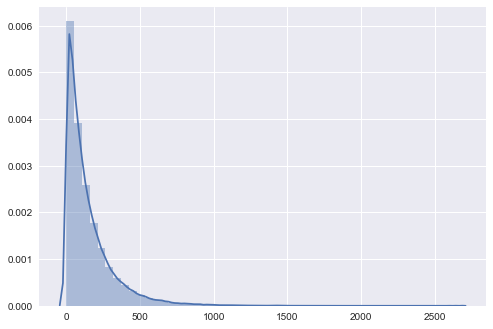

In [4]:
sns.distplot(endog[endog > 0])

A typical problem would be to try to improve the GLM by choosing an appropriate value for the `var_power` parameter. That's often difficult, but it can be made easier by using the scipy's `minimize_scalar` function which will seek the best value of `p`. To show this works, let's initially set `p` to be some ludicrious value and see if the `minimize_scalar` moves us in the right direction.

In [5]:
res = sm.GLM(endog, exog, family=sm.families.Tweedie(link=sm.families.links.log, var_power=1.1)).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99980
Model Family:                 Tweedie   Df Model:                           19
Link Function:                    log   Scale:                   113.453789434
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 24 Apr 2017   Deviance:                   9.5545e+06
Time:                        17:52:57   Pearson chi2:                 1.13e+07
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0634      0.035    145.996      0.000       4.995       5.131
x1             0.3728      0.016     23.421      0.0

In [6]:
def loglike_p(p):
    return -tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), method='bounded')
print(opt)

     fun: 481747.12621092948
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 1.3454076982488605


Sure enough, we move in the right direction.

Now, let's run the GLM using the updated value of `p`.

In [7]:
res2 = sm.GLM(endog, exog, family=sm.families.Tweedie(link=sm.families.links.log, var_power=opt.x)).fit()
print(res.summary())

def loglike_p(p):
    return -tweedie(mu=res2.mu, p=p, phi=res2.scale).logpdf(res2._endog).sum()

opt2 = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), method='bounded')
print(opt2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99980
Model Family:                 Tweedie   Df Model:                           19
Link Function:                    log   Scale:                   113.453789434
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 24 Apr 2017   Deviance:                   9.5545e+06
Time:                        17:53:08   Pearson chi2:                 1.13e+07
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0634      0.035    145.996      0.000       4.995       5.131
x1             0.3728      0.016     23.421      0.0

Still moving in the right direction.

In [8]:
res3 = sm.GLM(endog, exog, family=sm.families.Tweedie(link=sm.families.links.log, var_power=opt2.x)).fit()
print(res.summary())

def loglike_p(p):
    return -tweedie(mu=res3.mu, p=p, phi=res3.scale).logpdf(res3._endog).sum()

opt3 = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), method='bounded')
print(opt3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99980
Model Family:                 Tweedie   Df Model:                           19
Link Function:                    log   Scale:                   113.453789434
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 24 Apr 2017   Deviance:                   9.5545e+06
Time:                        17:53:18   Pearson chi2:                 1.13e+07
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0634      0.035    145.996      0.000       4.995       5.131
x1             0.3728      0.016     23.421      0.0

Still moving... After enough back-and-forth guesses, you should approach the optimal `p`. For reasons I don't fully understand, the estimated `p` won't quite match the initial guess provided earlier. But we are moving in the right direction!